# Software test (Cellranger v6.1 vs Starsolo (Gene Velocyto))

# Software testing - Preprocessing

<div class="alert alert-warning">

**What these notebooks do**
    
The following collection of notebooks compares data of the data of the snrna human atlas of Siletti et.al (10X176-1, 10X176-2) to data of the snrna human atlas of van Regteren Altena et. al. (UMC-AR-g004-SCI7T024_S1_L004, UMC-AR-g004-SCI7T024_S2_L004). Both are aligned with two differet aligners: Starsolo and Cellranger 6.1. All data objects were aligned to the standard ensemble 109 human reference genome. This test aims to identify the disparity created by the different reference genomes and if they can be used interchangably. An additional comparison is made between cellranger + standard reference genome vs starsolo + custom reference genome.

The collection of notebooks contains four main sections: 1) Preprocessing, 2) Filtering, 3) Normalization and Clustering, 4) Merging and Clustering
    
<br>   
    
**What the first section (Preprocessing) does**
    
This section takes the -just aligned- h5 files and shapes the data with annotations (e.g. doublet amount). This additional information will be used to filter the data and make it ready for subsequent processing. There will be one for each h5 file: *_preprocessed.h5ad files which contain all necessary annotation for subsequent filtering. The section can be split up in the following subsections:

* Doublet detection <br>
* Adding quality metrics and mitochondrial gene removal<br>
  
    
<br>   
    
**What the second section (Filtering) does**

This section visualizes various annotation values and filters the data based on a threshold made on the observations/domain knowledge. The section can be split up in the following subsections:

* Doublet filtering <br>
* UMIs and gene counts filtering <br>
    
<br> 
    
**What the third section (Normalization and Clustering) does**
    
This section normalizes the data based on sequencing depth and gene length so the cells are comparable. Subsequently dimensional reduction and clustering are performed. The section can be split up in the following subsections:

* Normalization <br>
* Dimensional reduction <br>
* Clustering with marker genes and property annotation <br>
    
<br>
    
**What the fourth section (Merging and Clustering) does**
    
This section merges the different datasets and performs normalization and clustering on the merged data. The section can be split up in the following subsections:

* Normalization <br>
* Dimensional reduction <br>
* Clustering with marker genes and property annotation <br>
</div>  



### Loading libraries
Using sc2_seurat environment, importing packages and setting parameters.

In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/bin/python
3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:40:17) 
[GCC 9.4.0]
sys.version_info(major=3, minor=9, micro=9, releaselevel='final', serial=0)


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))#embed HTML within IPython notebook and make containers 90% of screen
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import os
import matplotlib.pyplot as plt

%matplotlib inline
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white') #figure resolution and background color

# This is used
# os.path.join('data/'+object_names[i][6:10]+'_preprocessed.h5ad')
#sc.logging.print_versions()

### h5 files

In [11]:
#Siletti custom and standard with star solo have already been preprocessed before
siletti_standard_CR='/home/hers_basak/jjiang/jack/outputs/count_files/homo_sap/siletti_2022/cellranger/outs/filtered_feature_bc_matrix.h5'
siletti_standard='/home/hers_basak/jjiang/jack/outputs/count_files/homo_sap/siletti_2022/starsolo/standard_109/Solo.out/Velocyto/raw/'


#Anna van Regteren Altena custom and standard with star solo have already been preprocessed before
altena_standard_CR='/home/hers_basak/jjiang/jack/outputs/count_files/homo_sap/van_regteren_altena_2023/cellranger/standard_109/UMC-AR-g004_R1/outs/filtered_feature_bc_matrix.h5'
altena_standard='/home/hers_basak/jjiang/jack/outputs/count_files/homo_sap/van_regteren_altena_2023/starsolo/standard_109/Solo.out/Velocyto/raw/'
altena_cellbender='/home/hers_basak/jjiang/jack/outputs/count_files/homo_sap/van_regteren_altena_2023/cellranger/standard_109/UMC-AR-g004/outs/UMC-AR-g004_cellbender.h5'


In [5]:
#set data path
os.chdir('/home/hers_basak/jjiang/jack/outputs/deliverables/0_software_version_testing_starsolo')

In [6]:
os.getcwd()

'/hpc/hers_basak/rnaseq_data/Basaklab/jjiang/outputs/deliverables/0_software_version_testing_starsolo'

## Load data
The .h5 files from 10x that we are using contains feature and barcode information. Empty barcodes are already filtered out from these files. Anndata objects will have same amounts of observations as the amount of barcodes are the same and they are not filtered, in contrast to Cell Ranger.

In [13]:
files = [siletti_standard_CR, altena_standard_CR, altena_cellbender]
names = ['siletti_standard_CR', 'altena_standard_CR', 'altena_cellbender'] #used for making variable names

numberobj = len(names)

object_names = list()

#locals() returns dictionary with all local variables and symbols
for i in range(numberobj):
    if i==2:
        locals()["adata"+"_"+names[i]] = sc.read_h5ad(files[i])
    else:
        locals()["adata"+"_"+names[i]] = sc.read_10x_h5(files[i])
    locals()["adata"+"_"+names[i]].var_names_make_unique()
    print("adata"+"_"+names[i],"is loaded")
    
    object_names.append("adata"+"_"+names[i]) # make list of objects for later
    


/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/anndata/utils.py:220: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


adata_siletti_standard_CR is loaded


/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/anndata/utils.py:220: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


adata_altena_standard_CR is loaded


AnnDataReadError: Above error raised while reading key '/' of type <class 'h5py._hl.files.File'> from /.

In [ ]:
files = [ siletti_standard, altena_standard]
samples= ['siletti_standard', 'altena_standard']
object_names =[]

paths=files

files = ['unspliced.mtx','spliced.mtx', 'ambiguous.mtx']
for j in range(len(samples)):
    for i in range(len(files)):
        locals()["adata"+"_"+files[i]]=sc.read_mtx(f'{paths[j]}/{files[i]}')

    data = [locals()['adata_unspliced.mtx'], locals()['adata_spliced.mtx'], locals()['adata_ambiguous.mtx']]
    adata = sum([adata.X for adata in data])

    locals()["adata"+"_"+samples[j]] = sc.AnnData(X=adata.transpose())

    locals()["adata"+"_"+samples[j]].obs_names = pd.read_csv(f'{paths[j]}/barcodes.tsv', sep='\t',header=None).iloc[:,0]
    locals()["adata"+"_"+samples[j]].var_names = pd.read_csv(f'{paths[j]}/features.tsv', sep='\t',header=None).iloc[:,1]
    
    locals()["adata"+"_"+samples[j]].var_names_make_unique()
    sc.pp.filter_cells( locals()["adata"+"_"+samples[j]], min_counts=500, inplace=True)
    print("adata"+"_"+samples[j],"is loaded")
    object_names.append("adata"+"_"+samples[j])

In [ ]:
print(adata_siletti_standard.var_names)

## Basic Preprocessing
### Doublet detection using scrublet
Doublets are droplets that captures two cells, which will lead to inconsistencies. So we need to detect and remove them. First we will annotate the objects with metadata.

https://github.com/swolock/scrublet
https://www.sciencedirect.com/science/article/pii/S2405471218304745

Following the advice of Chromium (below), for 8000 cells recovered 6.10%.
> https://uofuhealth.utah.edu/huntsman/shared-resources/gba/htg/single-cell/genomics-10x.php


In [ ]:
names = ['siletti_standard_CR','siletti_standard', 'altena_standard_CR','altena_standard', 'altena_cellbender]'

In [ ]:
object_names=['adata_siletti_standard_CR','adata_siletti_standard', 'adata_altena_standard_CR','adata_altena_standard', 'adata_altena_cellbender']

In [ ]:
numberobj=len(names)

In [ ]:
#manually adding metadata due to lack of metadata file
for i in range(numberobj):
    locals()[object_names[i]].obs['species'] = ['Homo sapien','Homo sapien','Homo sapien','Homo sapien','Homo sapien'][i]
    locals()[object_names[i]].obs['sample_group'] = ['10X194-6_S31','10X194-6_S31','g004','g004','g004'][i]
    locals()[object_names[i]].obs['atlas'] = ['siletti','siletti','altena','altena','altena'][i]
    locals()[object_names[i]].obs['reference'] = ['standard','standard','standard','standard','standard'][i]
    locals()[object_names[i]].obs['software'] = ['cellranger','starsolo','cellranger','starsolo','cellranger'][i]
#viewing object annotations
for i in range(numberobj):
    print(locals()[object_names[i]].shape)
    

thr = 0.20
expected_doublet_rates = [0.061,0.061,0.039,0.039,0.039] 
for i in range(numberobj):
    #predicts doublets and adds a score to objects
    sc.external.pp.scrublet(locals()[object_names[i]], expected_doublet_rate=expected_doublet_rates[i], stdev_doublet_rate=0.02, 
                            synthetic_doublet_umi_subsampling=1.0, knn_dist_metric='euclidean', normalize_variance=True, 
                            log_transform=False, mean_center=True, n_prin_comps=30, use_approx_neighbors=True, 
                            get_doublet_neighbor_parents=False, n_neighbors=None, threshold=thr, verbose=True, copy=False, random_state=0)
    #plot histogram of doublet scores(doesnt work in loop)
    sc.external.pl.scrublet_score_distribution(locals()[object_names[i]], scale_hist_obs='log', scale_hist_sim='linear', figsize=(8, 3),
                                               show=True,return_fig=True)


Check how many cells are higher than the threshold

In [8]:
for i in range(numberobj):
    print(names[i],'\n',locals()[object_names[i]].obs['predicted_doublet'].value_counts(),'\n')

KeyError: 'predicted_doublet'

### Scrublet simulation plot

siletti_standard_CR


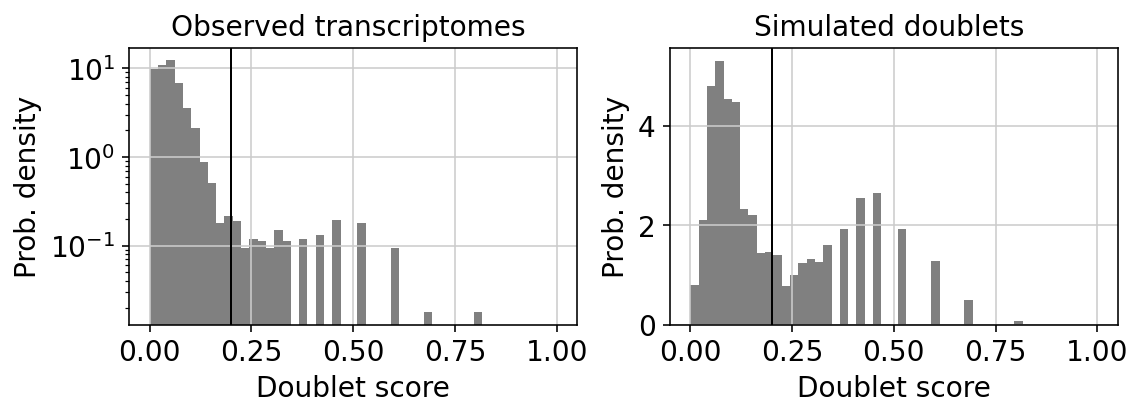

siletti_standard


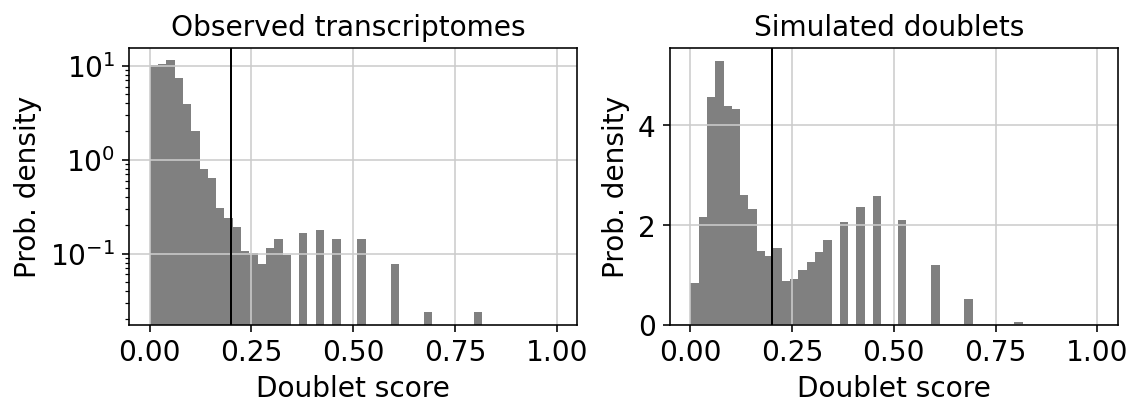

altena_standard_CR


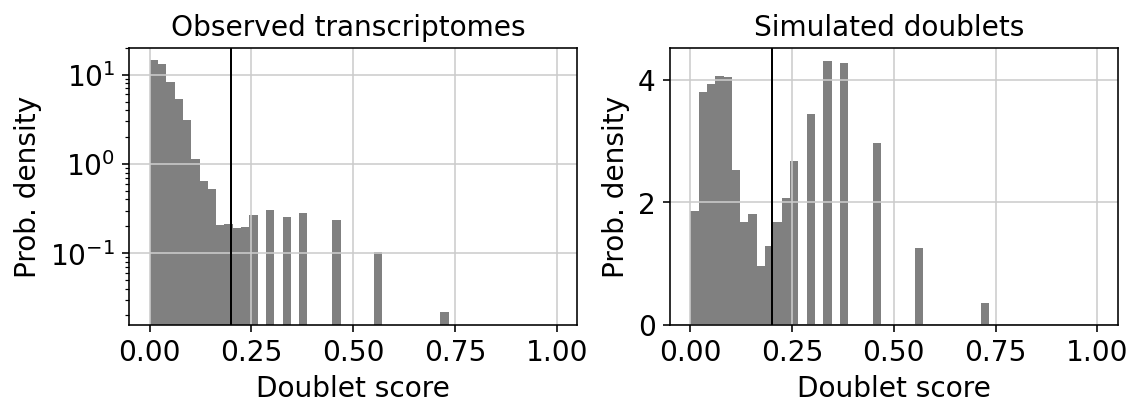

altena_standard


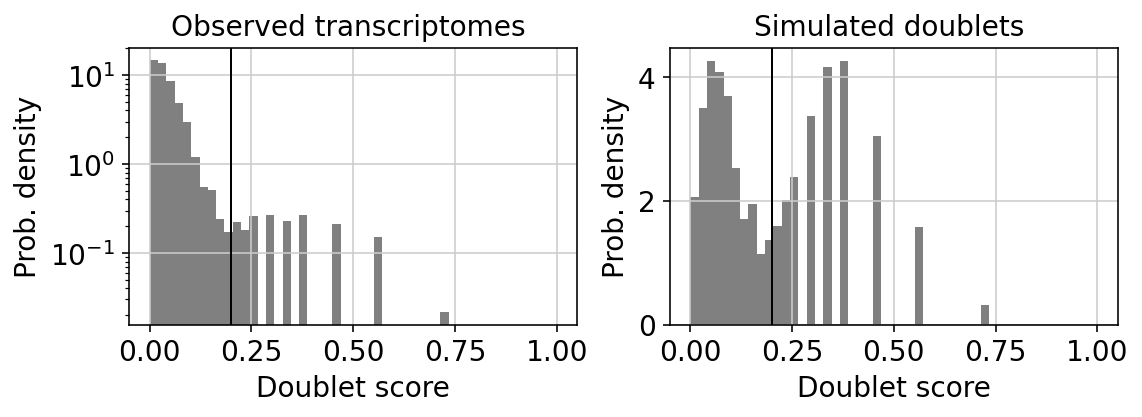

In [25]:
%matplotlib inline
for i in range(numberobj):
    print(names[i])
    sc.external.pl.scrublet_score_distribution(locals()[object_names[i]], scale_hist_obs='log', scale_hist_sim='linear', figsize=(8, 3),show=True,return_fig=True)

### Add QC and get rid of mitochondrial genes

In [26]:
adata_siletti_standard_CR.obs['sample_group']


AAACCCAAGTTTCGAC-1    10X194-6_S31
AAACCCACATCGTTCC-1    10X194-6_S31
AAACCCAGTTATTCTC-1    10X194-6_S31
AAACCCATCGAGAGCA-1    10X194-6_S31
AAACCCATCGGAGTGA-1    10X194-6_S31
                          ...     
TTTGGTTGTGAGTAAT-1    10X194-6_S31
TTTGGTTTCGCCTATC-1    10X194-6_S31
TTTGGTTTCTAAGAAG-1    10X194-6_S31
TTTGTTGCACCCAAGC-1    10X194-6_S31
TTTGTTGCAGGCATTT-1    10X194-6_S31
Name: sample_group, Length: 8217, dtype: object

<b> check this: sc.pp.calculate_qc_metrics() </b> <br>
expr_type: kind of values in X (str)<br>
var_type: kind of variables (str)<br>
qc_vars: keys for variables you want to control (collection of str)<br>
percent_top: proportions of top genes to cover, for cummulative proportion of counts (collection of int)<br>
layer: alternative layers for expression data (str)<br>
use_raw: use adata.raw.X for expression values (bool)<br>
inplace: place metrics in adata (bool)<br>
log1p: compute log1p transformed annotations, for very small values (bool)<br>
<br>
<b> return features obs </b> <br>
n_genes_by_counts: The number of genes with at least 1 count in a cell. <br>
total_counts: Total number of counts for a cell. <br>
total_counts_mt:Total number of mt gene counts for a cell. <br>
pct_counts_mt: Proportion (%) of total counts for a cell which are mitochondrial. <br> 
n_genes: Number of genes with a positive count. <br>
total_counts_ribo: Total number of ribosomal counts for a cell. <br>
pct_counts_ribo: Proportion of total counts for a cell which are ribosomal.

In [27]:
import numpy as np

for i in range(numberobj):
    #add mt variable annotation indicating if a gene is ribosomal or not (bool)
    if locals()[object_names[i]].obs['species'][0] == 'Homo sapien':
        locals()[object_names[i]].var['mt'] = locals()[object_names[i]].var_names.str.startswith('MT-')
    elif locals()[object_names[i]].obs['species'][0] == 'Mus musculus':
        locals()[object_names[i]].var['mt'] = locals()[object_names[i]].var_names.str.startswith('mt-') 
        
    if locals()[object_names[i]].obs['species'][0] == 'Homo sapien':
        locals()[object_names[i]].var['ribo'] = locals()[object_names[i]].var_names.str.startswith('RP')
    elif locals()[object_names[i]].obs['species'][0] == 'Mus musculus':
        locals()[object_names[i]].var['ribo'] = locals()[object_names[i]].var_names.str.startswith('Rp')
    
    sc.pp.calculate_qc_metrics(locals()[object_names[i]], expr_type='counts', var_type='genes', qc_vars=('mt','ribo'), percent_top= (), layer= None, use_raw= False, inplace=True, log1p=True)
     
    locals()[object_names[i]].var_names_make_unique()
    sc.pp.filter_cells(locals()[object_names[i]], min_genes=1) #remove all cells with 0 genes
                 
    # The following is to solve a save issue. Probably because of the NA valies in ther 'predicted_doublet' slot
    locals()[object_names[i]].obs['predicted_doublet'] =  locals()[object_names[i]].obs['predicted_doublet'].astype('str')

    

Checking median number of mitochondrial genes, genes and UMIs per cell to have an idea of the quality of each run:

In [28]:
print("Median numbers before filtering mt genes")
for i in range(numberobj):
    print(
         object_names[i],'\n',"\tmito%:",np.median(locals()[object_names[i]].obs['pct_counts_mt']),'\n',"\tmedian genes/nuclei:",np.median(locals()[object_names[i]].obs['n_genes']),'\n', 
            "\tmedian reads/nuclei:",np.median(locals()[object_names[i]].obs['total_counts']),'\n',
           "\tmean genes/nuclei:",int(np.mean(locals()[object_names[i]].obs['n_genes'])),'\n',
         "\tmean reads/nuclei:",  int(np.mean(locals()[object_names[i]].obs['total_counts'])), '\n')
    

Median numbers before filtering mt genes
adata_siletti_standard_CR 
 	mito%: 0.29912326 
 	median genes/nuclei: 2788.0 
 	median reads/nuclei: 6222.0 
 	mean genes/nuclei: 3650 
 	mean reads/nuclei: 11779 

adata_siletti_standard 
 	mito%: 0.2979146 
 	median genes/nuclei: 2670.0 
 	median reads/nuclei: 6162.0 
 	mean genes/nuclei: 3470 
 	mean reads/nuclei: 11615 

adata_altena_standard_CR 
 	mito%: 0.09104913 
 	median genes/nuclei: 2991.5 
 	median reads/nuclei: 7667.0 
 	mean genes/nuclei: 3074 
 	mean reads/nuclei: 8605 

adata_altena_standard 
 	mito%: 0.089630835 
 	median genes/nuclei: 2856.0 
 	median reads/nuclei: 7599.0 
 	mean genes/nuclei: 2926 
 	mean reads/nuclei: 8519 



Filtering out mito genes to determine number of non mitochondrial genes:

In [29]:
for i in range(numberobj):
    #list all non mitochondrial genes for subsetting the columns
    if locals()[object_names[i]].obs['species'][0] == 'Homo sapien':
         non_mito_genes_list = [name for name in locals()[object_names[i]].var_names if not name.startswith('MT-')]
    elif locals()[object_names[i]].obs['species'][0] == 'Mus musculus':
        non_mito_genes_list = [name for name in locals()[object_names[i]].var_names if not name.startswith('mt-')]
    
    
    locals()[object_names[i]] = locals()[object_names[i]][:, non_mito_genes_list].copy()
    
    locals()[object_names[i]].obs['total_counts_mito'] =  locals()[object_names[i]].obs['total_counts']
    
    
    #recalculate the number of genes, because some cells only had mt gene counts
    sc.pp.filter_cells(locals()[object_names[i]], min_genes=1)

### Recalculate metrics 
Note that the qc_vars=None because we want to keep the mt%."


In [30]:
for i in range(numberobj):
    sc.pp.calculate_qc_metrics(locals()[object_names[i]], expr_type='counts', var_type='genes', qc_vars=(), percent_top= (), layer= None, use_raw= False, inplace=True, log1p=True)
print(adata_siletti_standard_CR.obs['total_counts'])
print(adata_siletti_standard_CR.obs['pct_counts_mt'])

AAACCCAAGTTTCGAC-1     3495.0
AAACCCACATCGTTCC-1     8579.0
AAACCCAGTTATTCTC-1     6431.0
AAACCCATCGAGAGCA-1     8486.0
AAACCCATCGGAGTGA-1    25807.0
                       ...   
TTTGGTTGTGAGTAAT-1      917.0
TTTGGTTTCGCCTATC-1    10579.0
TTTGGTTTCTAAGAAG-1    29729.0
TTTGTTGCACCCAAGC-1    10720.0
TTTGTTGCAGGCATTT-1    19857.0
Name: total_counts, Length: 8217, dtype: float32
AAACCCAAGTTTCGAC-1    0.057192
AAACCCACATCGTTCC-1    0.197766
AAACCCAGTTATTCTC-1    0.108729
AAACCCATCGAGAGCA-1    0.023563
AAACCCATCGGAGTGA-1    0.757576
                        ...   
TTTGGTTGTGAGTAAT-1    1.397849
TTTGGTTTCGCCTATC-1    0.741227
TTTGGTTTCTAAGAAG-1    0.575232
TTTGTTGCACCCAAGC-1    1.061375
TTTGTTGCAGGCATTT-1    0.401264
Name: pct_counts_mt, Length: 8217, dtype: float32


Check for the basic statistics

In [31]:
sc.set_figure_params(figsize=[8,8])

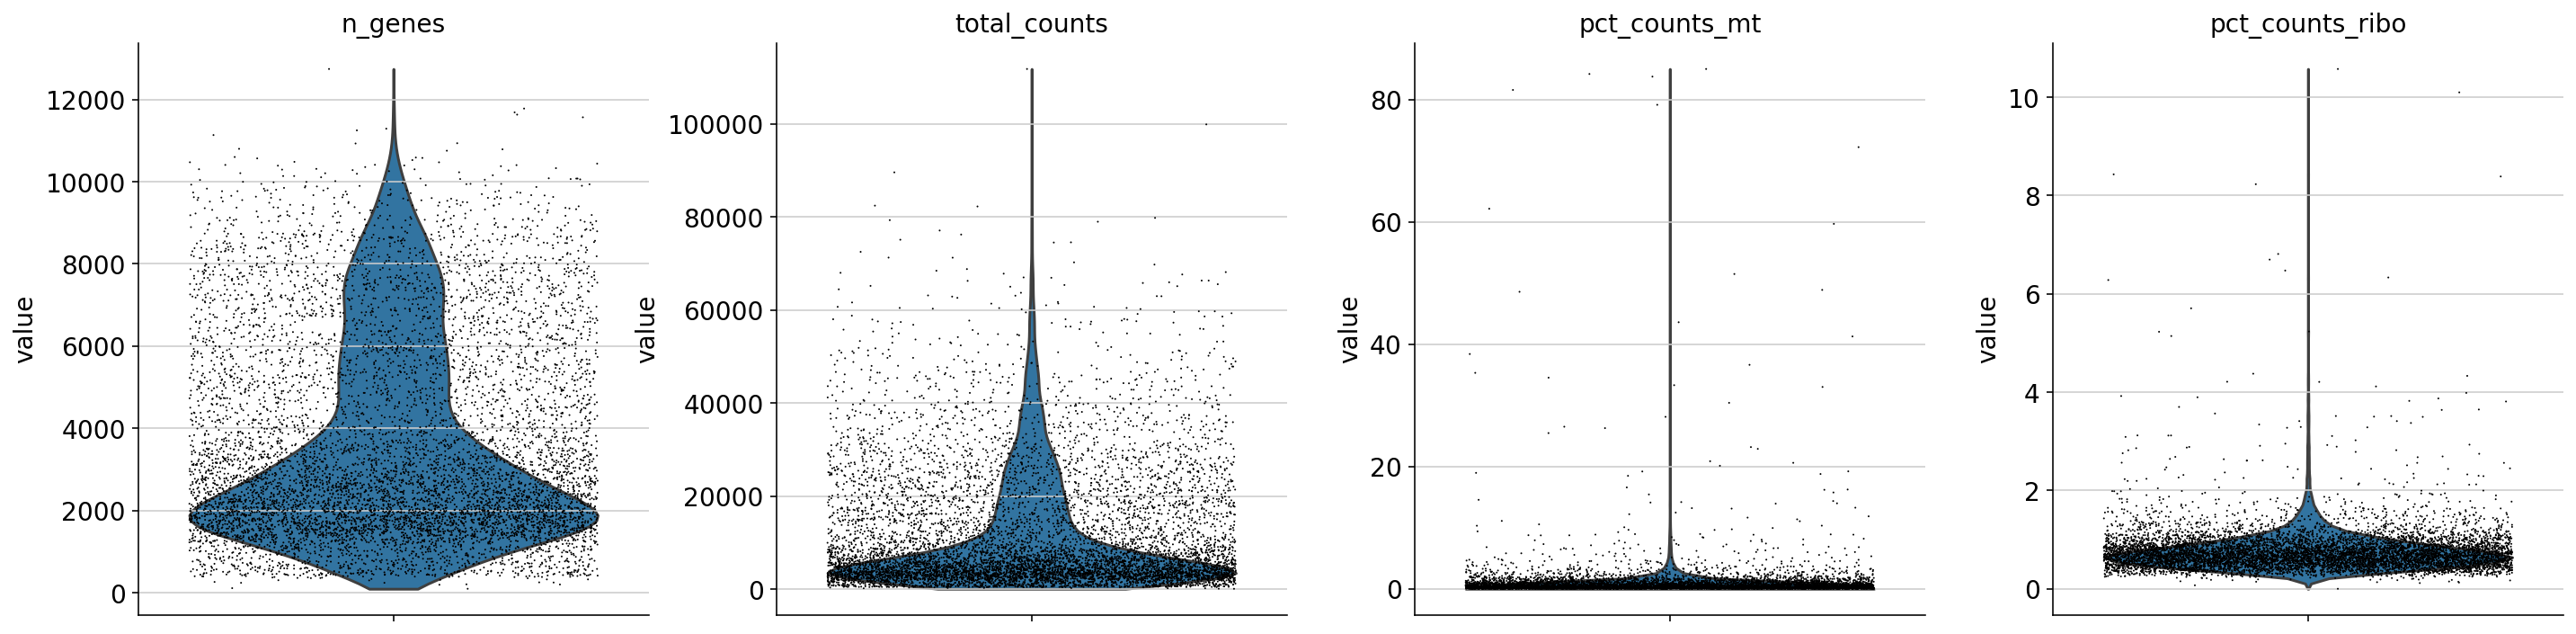

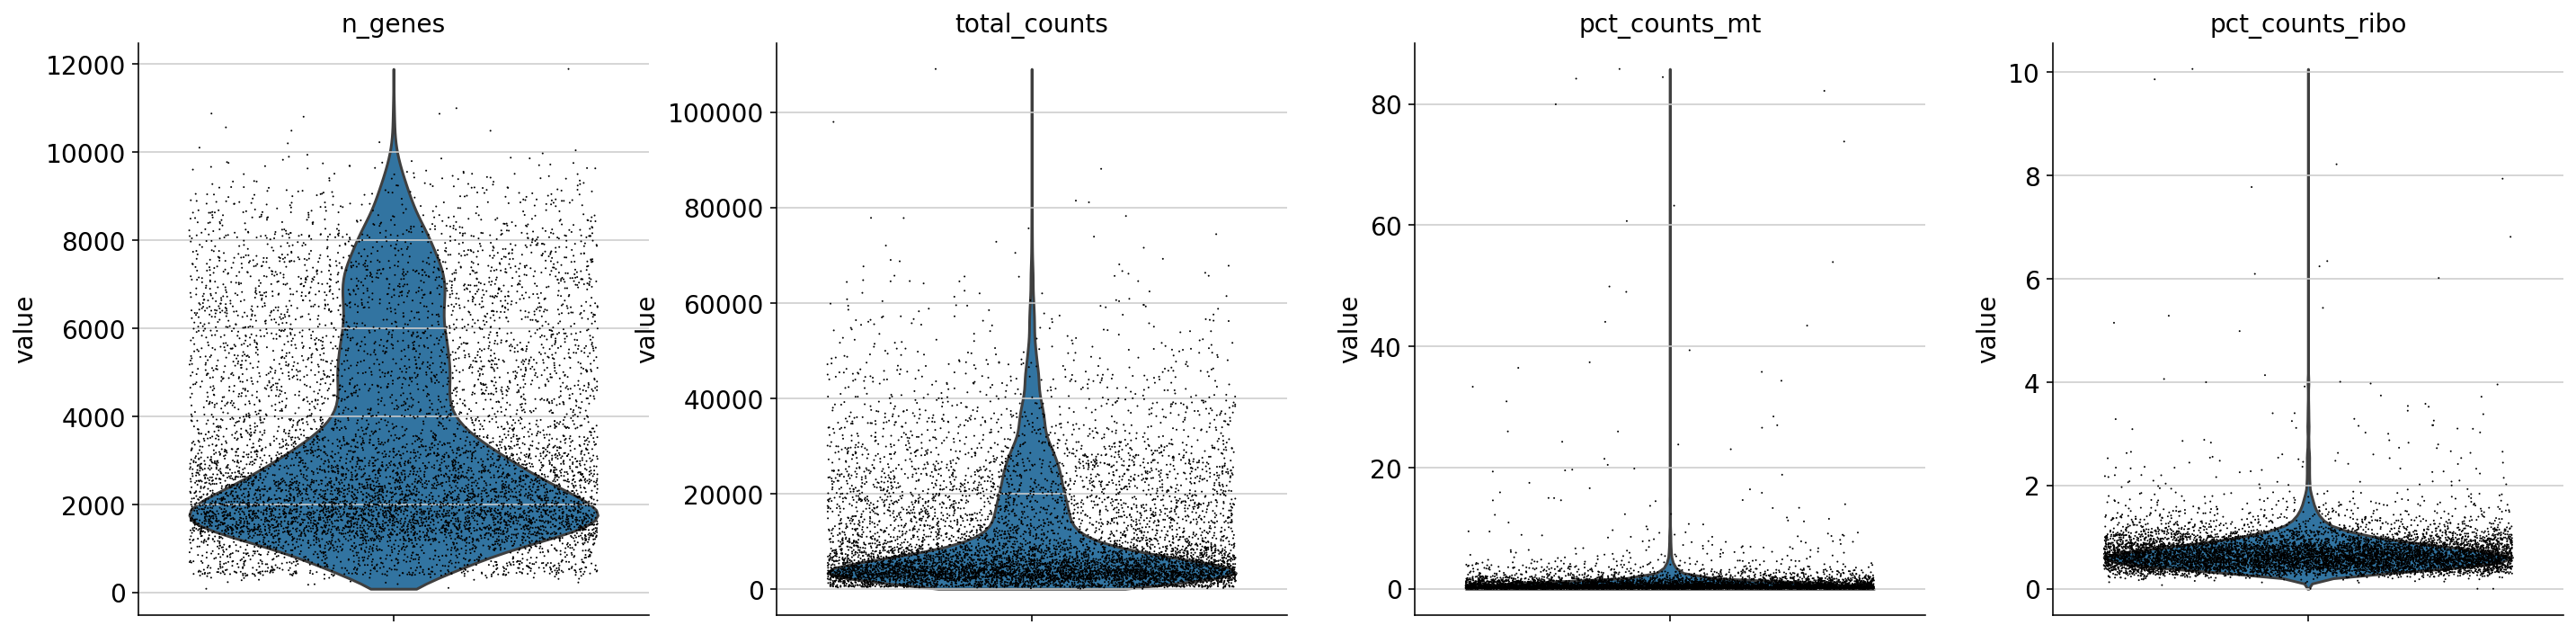

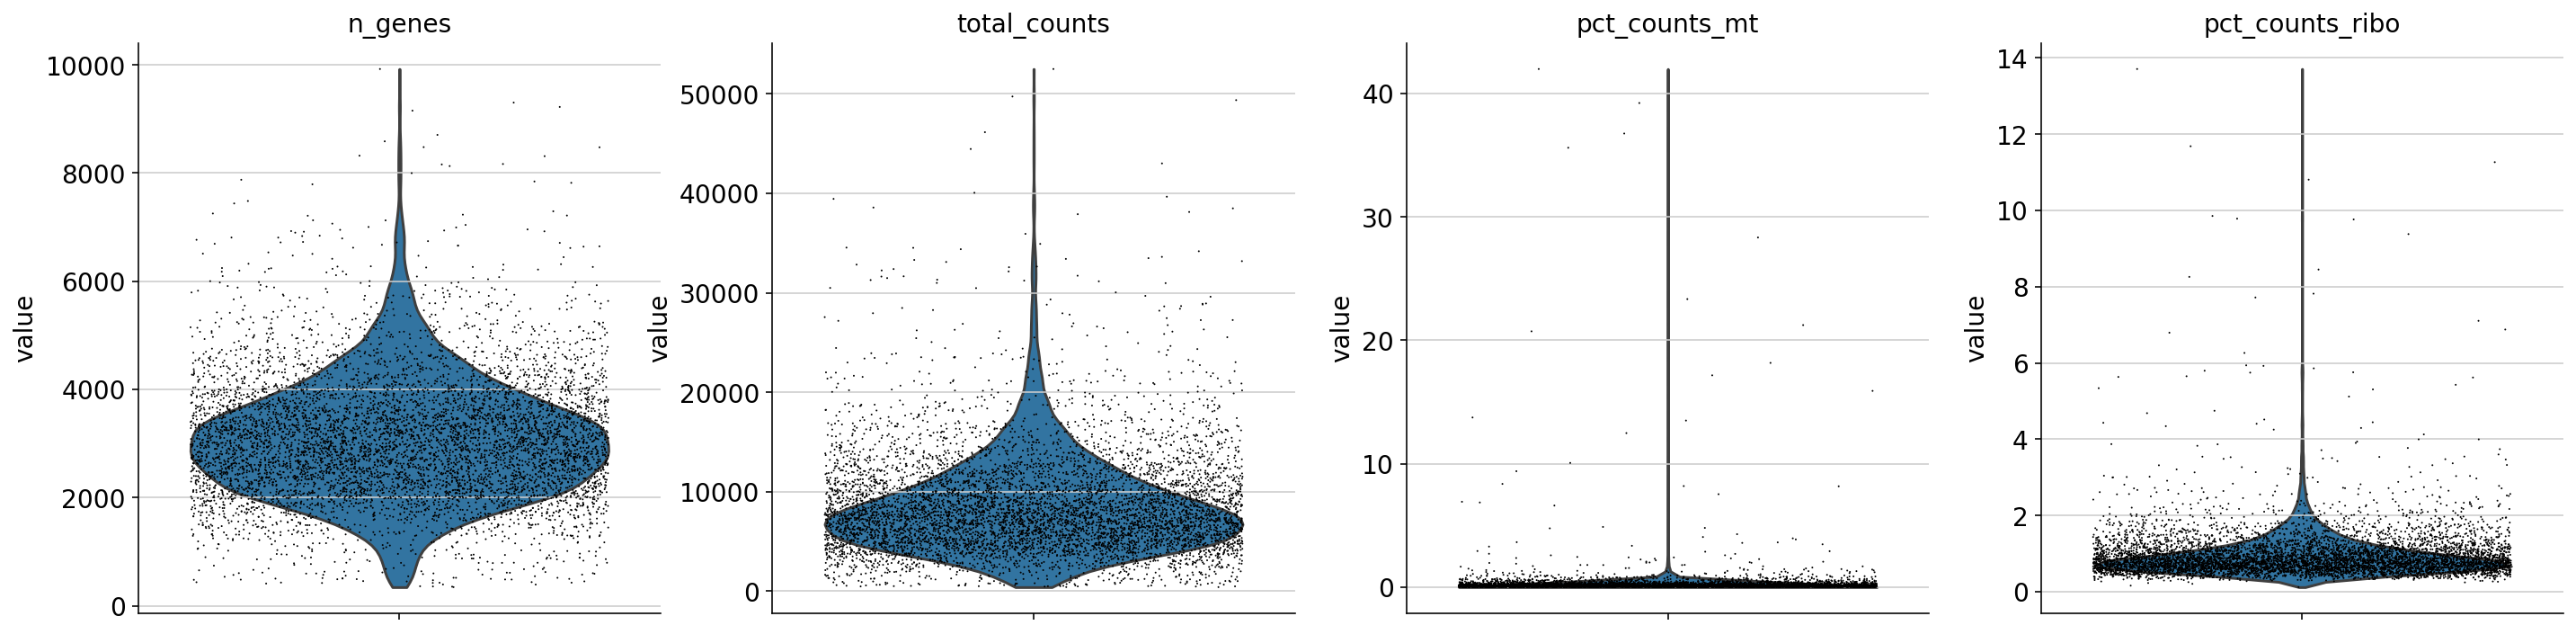

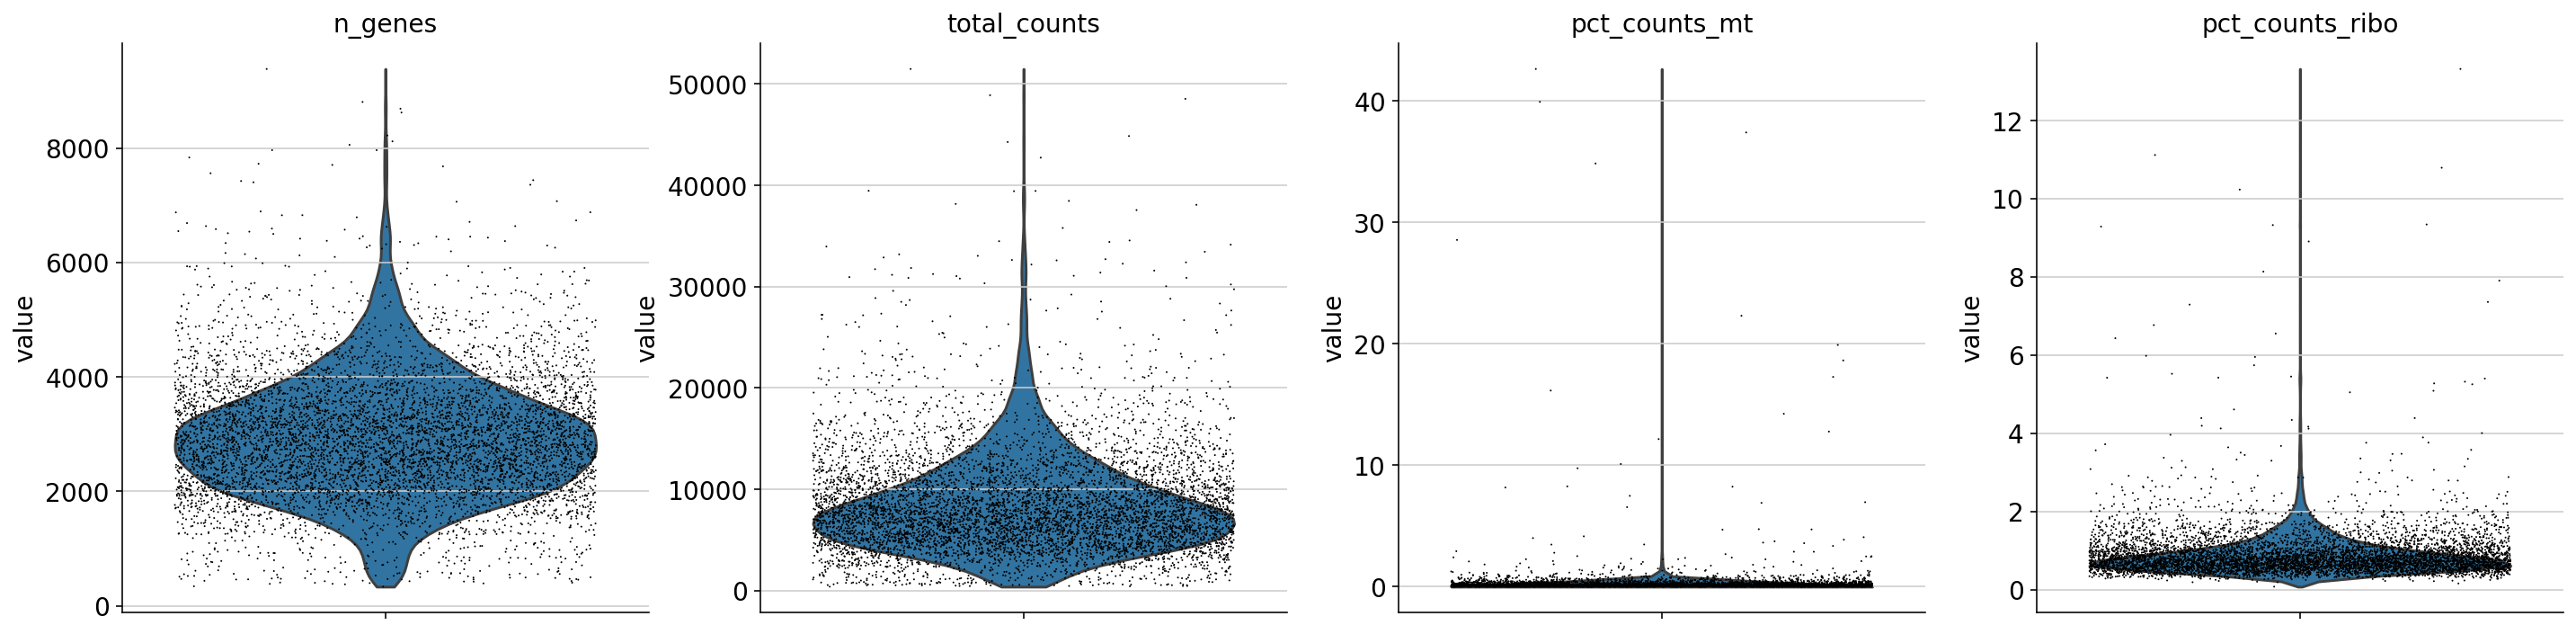

In [32]:
%matplotlib inline
for i in range(numberobj):
    sc.pl.violin(locals()[object_names[i]], ['n_genes', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter=0.4, multi_panel=True,size =1)#,save= object_names[i]+"_prefilter_all.pdf")
    plt.show()

In [33]:
print("Median numbers without mitochondrial reads\n")


for i in range(numberobj):
    median_counts = np.median(locals()[object_names[i]].obs['total_counts_mito'])
    mean_counts= int(np.mean(locals()[object_names[i]].obs['total_counts_mito']))

    median_counts_mito = np.median(locals()[object_names[i]].obs['total_counts']) 
    mean_counts_mito =int(np.mean(locals()[object_names[i]].obs['total_counts']))

    median_difference = median_counts - median_counts_mito 
    mean_difference = mean_counts -  mean_counts_mito
    
    pct_median_diff = median_difference / median_counts
    pct_mean_diff = mean_difference/mean_counts
    
    print(object_names[i],'\n',"\tmedian genes/nuclei:",np.median(locals()[object_names[i]].obs['n_genes']), '\n',
            "\tmedian reads/nuclei:",median_counts, '(',median_difference,'\t', pct_median_diff,'%',')','\n',
           "\tmean genes/nuclei:",int(np.mean(locals()[object_names[i]].obs['n_genes'])),'\n',
         "\tmean reads/nuclei:", mean_counts, '(',mean_difference,'\t', pct_mean_diff,'%',')','\n')

Median numbers without mitochondrial reads

adata_siletti_standard_CR 
 	median genes/nuclei: 2781.0 
 	median reads/nuclei: 6222.0 ( 26.0 	 0.0041787205 % ) 
 	mean genes/nuclei: 3642 
 	mean reads/nuclei: 11779 ( 84 	 0.007131335427455641 % ) 

adata_siletti_standard 
 	median genes/nuclei: 2666.0 
 	median reads/nuclei: 6162.0 ( 18.0 	 0.0029211296 % ) 
 	mean genes/nuclei: 3463 
 	mean reads/nuclei: 11615 ( 83 	 0.007145931984502798 % ) 

adata_altena_standard_CR 
 	median genes/nuclei: 2988.0 
 	median reads/nuclei: 7667.0 ( 13.0 	 0.0016955785 % ) 
 	mean genes/nuclei: 3069 
 	mean reads/nuclei: 8605 ( 12 	 0.0013945380592678676 % ) 

adata_altena_standard 
 	median genes/nuclei: 2851.0 
 	median reads/nuclei: 7599.0 ( 9.0 	 0.0011843664 % ) 
 	mean genes/nuclei: 2920 
 	mean reads/nuclei: 8519 ( 12 	 0.0014086160347458621 % ) 



### Save preprocessed files

In [34]:
for i in range(numberobj):
    locals()[object_names[i]].write(os.path.join('data/'+object_names[i][6:]+'_preprocessed.h5ad'))

In [35]:
!ls data/

altena_standard_CR_f1_processed_1.h5ad
altena_standard_CR_f1_reg_processed_1.h5ad
altena_standard_CR_filtered_1.h5ad
altena_standard_CR_preprocessed.h5ad
altena_standard_preprocessed.h5ad
siletti_standard_CR_f1_processed_1.h5ad
siletti_standard_CR_f1_reg_processed_1.h5ad
siletti_standard_CR_filtered_1.h5ad
siletti_standard_CR_preprocessed.h5ad
siletti_standard_preprocessed.h5ad
